<a href="https://colab.research.google.com/github/marcolussetti/opendotadump-tools/blob/master/analysis/heroes_winratio/GraphWinRatios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Hero Ratios
This notebook will produce graphs of the heroes' win ratio on a per-day basis.

## Processing

### Constants for configuration

In [0]:
CSV_INPUT_FILE = "https://raw.githubusercontent.com/marcolussetti/opendotadump-tools/master/data/heroes_winratio_csvs/win_ratios.csv"
OPENDOTA_API_HEROES_ENDPOINT = "https://api.opendota.com/api/heroes/"

In [0]:
CSV_POPULARITY_FILE = "https://raw.githubusercontent.com/marcolussetti/opendotadump-tools/master/data/heroes_picks_csvs/stable-picks_heroes-names_by_hero.csv"

### Imports & Configuration

In [1]:
# If plotnine is not installed:
!pip install plotnine

# If using on google colab, might need to update statsmodels version
!pip install statsmodels -U

# If not installed
!pip install requests

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import pandas as pd
import requests
from plotnine import *
from scipy.spatial import distance
from datetime import datetime, timedelta
import numpy as np

In [0]:
%matplotlib inline

### Import data

In [0]:
# Load input csv
df = pd.read_csv(CSV_INPUT_FILE, index_col=0)
df_popularity = pd.read_csv(CSV_POPULARITY_FILE, header=None)
df_popularity.columns = ["Hero", "Count"]

In [88]:
df_popularity.sort_values("Count", ascending=False)[:10]["Hero"]

13               Pudge
33              Sniper
42    Phantom Assassin
72             Invoker
7           Juggernaut
20          Windranger
5          Drow Ranger
30                Riki
1                  Axe
60       Bounty Hunter
Name: Hero, dtype: object

### Examine the data

#### Structure of dataset

In [0]:
df.head()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
2011-11-23,0.553107,0.400113,NaN,0.492987,0.517582,0.479532,0.510188,0.509298,0.517424,0.402626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-24,0.531292,0.412890,NaN,0.516638,0.521612,0.486762,0.507148,0.489245,0.532864,0.396914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-25,0.529384,0.398871,NaN,0.500591,0.504444,0.481317,0.509161,0.497667,0.516503,0.388009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-26,0.550840,0.401352,NaN,0.507012,0.512707,0.486092,0.530201,0.501024,0.511480,0.406340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-27,0.550095,0.409180,NaN,0.517050,0.523726,0.463617,0.492048,0.478655,0.514457,0.407563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df.describe()

,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,Morphling,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
count,1614.000000,1614.000000,1515.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,1614.000000,...,1088.000000,864.000000,600.000000,892.000000,892.000000,817.000000,817.000000,522.000000,438.000000,131.000000
mean,0.456636,0.488019,0.427213,0.513060,0.519007,0.521076,0.503502,0.488650,0.521472,0.447444,...,0.518748,0.479324,0.499421,0.449747,0.439362,0.482088,0.514350,0.399904,0.490830,0.429125
std,0.024544,0.048796,0.017592,0.026151,0.036298,0.047080,0.022488,0.028417,0.015169,0.022398,...,0.029467,0.027343,0.029655,0.013893,0.036443,0.031198,0.014519,0.019726,0.018359,0.012640
min,0.218546,0.034583,0.370353,0.383039,0.163773,0.065187,0.432836,0.094221,0.414471,0.199471,...,0.213485,0.163949,0.000000,0.347868,0.237929,0.268516,0.267366,0.351949,0.454027,0.366553
25%,0.437936,0.465883,0.414307,0.495011,0.508930,0.507699,0.485882,0.475842,0.510326,0.434295,...,0.505759,0.459005,0.481235,0.441828,0.409870,0.460769,0.507090,0.378990,0.469820,0.426061
50%,0.451800,0.500239,0.425775,0.512921,0.522300,0.518878,0.507423,0.488860,0.522712,0.444989,...,0.515917,0.489549,0.489794,0.447360,0.451902,0.482985,0.513297,0.404520,0.501003,0.433191
75%,0.470222,0.512982,0.439628,0.535478,0.547191,0.539649,0.524303,0.502378,0.531787,0.456210,...,0.531690,0.498555,0.519849,0.457140,0.467010,0.492610,0.523775,0.416949,0.505215,0.436166
max,0.553107,0.558028,0.506272,0.625000,0.563725,0.639694,0.549237,0.559599,0.550600,0.592593,...,0.591515,0.510124,0.538875,0.499702,0.492402,0.571432,0.544722,0.434519,0.513162,0.442472


#### Overall heroes  metrics

In [6]:
heroes_highest_winratio = df.mean().sort_values(ascending=False)[:10]  # Average of win ratio
heroes_highest_winratio

Abaddon              0.582601
Ursa                 0.563463
Centaur Warrunner    0.553461
Omniknight           0.547864
Spectre              0.547851
Lich                 0.545892
Zeus                 0.541292
Venomancer           0.538423
Silencer             0.536422
Treant Protector     0.535558
dtype: float64

In [7]:
# Heroes with the most variation
heroes_winratio_std = df.std().sort_values(ascending=False)[:10]  # Standard deviation of pick frequency
heroes_winratio_std

Omniknight          0.060774
Necrophos           0.050792
Axe                 0.048796
Troll Warlord       0.047281
Drow Ranger         0.047080
Death Prophet       0.043993
Templar Assassin    0.042558
Warlock             0.041890
Dazzle              0.041045
Treant Protector    0.040323
dtype: float64

In [8]:
# Heroes with highest least variation
heroes_lowest_winratio = df.mean().sort_values(ascending=True)[:10]  # Average of win ratio
heroes_lowest_winratio

Oracle          0.399904
Bane            0.427213
Arc Warden      0.429125
Io              0.435870
Earth Spirit    0.439362
Tiny            0.444174
Morphling       0.447444
Shadow Demon    0.448645
Ember Spirit    0.449747
Alchemist       0.450268
dtype: float64

#### Exploratory graphing

In [0]:
df_with_date_col = df.copy(deep=True)
df_with_date_col = df_with_date_col.reset_index(level=0)
df_with_date_col.columns = ["Date", *df_with_date_col.columns[1:]]

In [10]:
df_with_date_col.head()

,Date,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,2011-11-23,0.553107,0.400113,NaN,0.492987,0.517582,0.479532,0.510188,0.509298,0.517424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-11-24,0.531292,0.412890,NaN,0.516638,0.521612,0.486762,0.507148,0.489245,0.532864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-11-25,0.529384,0.398871,NaN,0.500591,0.504444,0.481317,0.509161,0.497667,0.516503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-11-26,0.550840,0.401352,NaN,0.507012,0.512707,0.486092,0.530201,0.501024,0.511480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-11-27,0.550095,0.409180,NaN,0.517050,0.523726,0.463617,0.492048,0.478655,0.514457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotni

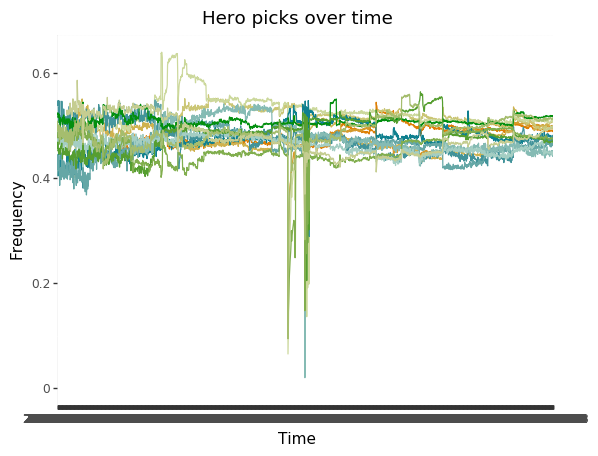

<ggplot: (8752073321178)>

In [11]:
basic_plot = (ggplot(df_with_date_col, aes())
 # Highest variance
 +geom_line(aes('Date', 'Phantom Assassin', group=1), color='#de7f05')
 +geom_line(aes('Date', 'Legion Commander', group=1), color='#d59a2b')
 +geom_line(aes('Date', 'Invoker', group=1), color='#cfb24f')
 +geom_line(aes('Date', 'Slark', group=1), color='#cbc675')
 +geom_line(aes('Date', 'Drow Ranger', group=1), color='#ccd89c')
 # Lowest variance
 +geom_line(aes('Date', 'Pugna', group=1), color='#0f808f')
 +geom_line(aes('Date', 'Chen', group=1), color='#42939a')
 +geom_line(aes('Date', 'Batrider', group=1), color='#65a7a6')
 +geom_line(aes('Date', 'Visage', group=1), color='#85bbb4')
 +geom_line(aes('Date', 'Enchantress', group=1), color='#a4cec3')
 # Highest popularity (skipping already used ones)
 +geom_line(aes('Date', 'Pudge', group=1), color='#038f0f')
 +geom_line(aes('Date', 'Sniper', group=1), color='#569e30')
 +geom_line(aes('Date', 'Windranger', group=1), color='#81ae4e')
 +geom_line(aes('Date', 'Juggernaut', group=1), color='#a5bd6e')
 +geom_line(aes('Date', 'Bounty Hunter', group=1), color='#c5cd91')
 #Config
 +ggtitle("Hero picks over time")
 +ylab("Frequency")
 +xlab("Time")
)
basic_plot

#### Reformat data for "easy" graphing

In [0]:
df_expl_graph = df.copy(deep=True)
# Condense values
df_expl_graph = df_expl_graph.stack()
df_expl_graph = df_expl_graph.reset_index()

df_expl_graph.columns = ["Day", "Hero", "Winratio"]

df_expl_graph["Day"] = df_expl_graph["Day"].apply(pd.to_datetime)

df_expl_graph["Week"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.week))
df_expl_graph["Month"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.month))
df_expl_graph["Year"] = df_expl_graph["Day"].apply(lambda date: date.year)


In [13]:
df_expl_graph.head()

,Day,Hero,Winratio,Week,Month,Year
0,2011-11-23,Anti-Mage,0.553107,2011-47,2011-11,2011
1,2011-11-23,Axe,0.400113,2011-47,2011-11,2011
2,2011-11-23,Bloodseeker,0.492987,2011-47,2011-11,2011
3,2011-11-23,Crystal Maiden,0.517582,2011-47,2011-11,2011
4,2011-11-23,Drow Ranger,0.479532,2011-47,2011-11,2011


In [0]:
df_highest_winratio = df_expl_graph[df_expl_graph["Hero"].isin(heroes_highest_winratio.keys())]
df_lowest_winratio = df_expl_graph[df_expl_graph["Hero"].isin(heroes_lowest_winratio.keys())]
df_winratio_std = df_expl_graph[df_expl_graph["Hero"].isin(heroes_winratio_std.keys())]

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


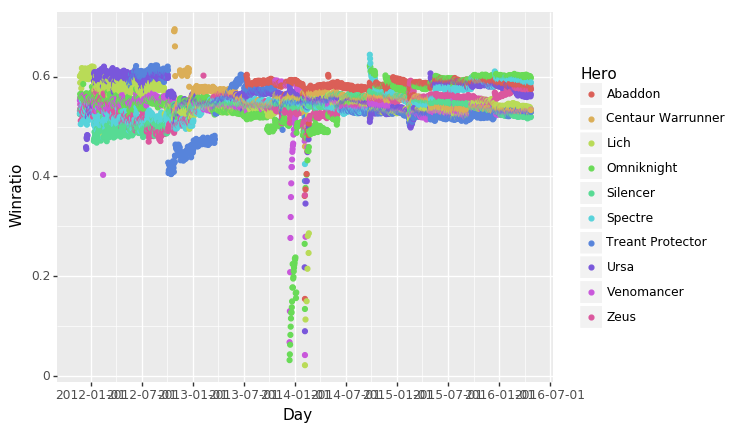

<ggplot: (-9223363283663772605)>

In [0]:
day_plot = (ggplot(df_highest_winratio, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


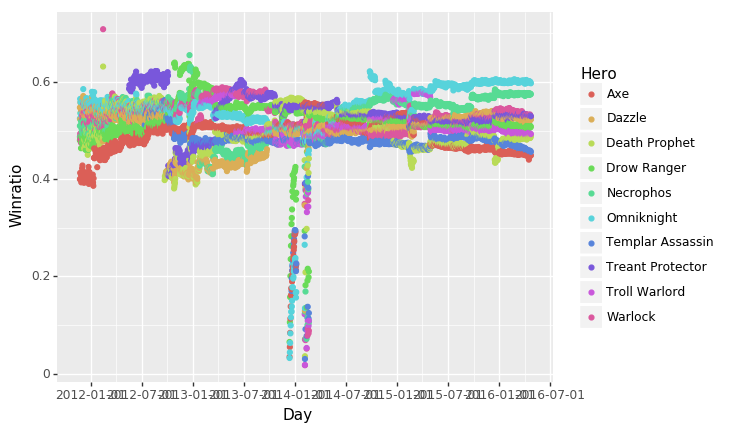

<ggplot: (8753190924145)>

In [0]:
day_plot_std = (ggplot(df_winratio_std, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot_std

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


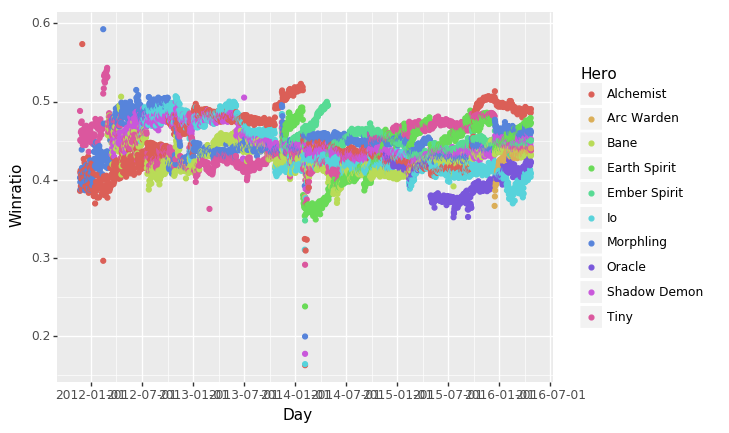

<ggplot: (-9223363283668360949)>

In [0]:
day_plot_lowest = (ggplot(df_lowest_winratio, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
day_plot_lowest

In [0]:
day_plot.save("highest_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)
day_plot_lowest.save("lowest_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)
day_plot_std.save("std_winratio_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: highest_winratio_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: lowest_winratio_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.6/dist

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


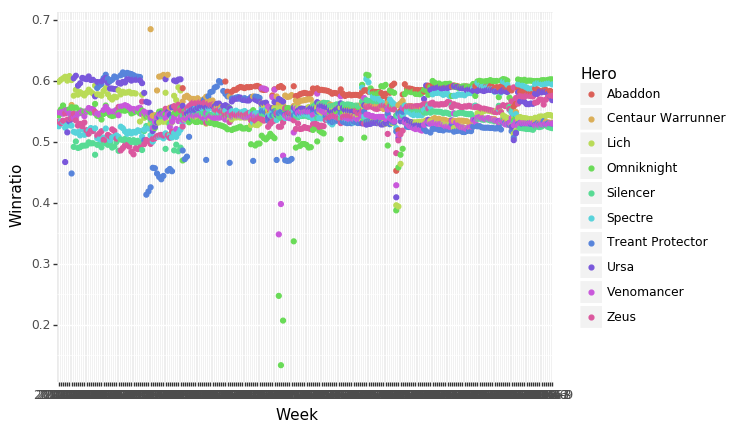

<ggplot: (8753190978361)>

In [0]:
week_plot = (ggplot(df_highest_winratio.groupby(["Week", "Hero"]).mean().reset_index(), aes(x="Week", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
week_plot

In [0]:
week_plot.save("highest_winratio_week_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_week_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


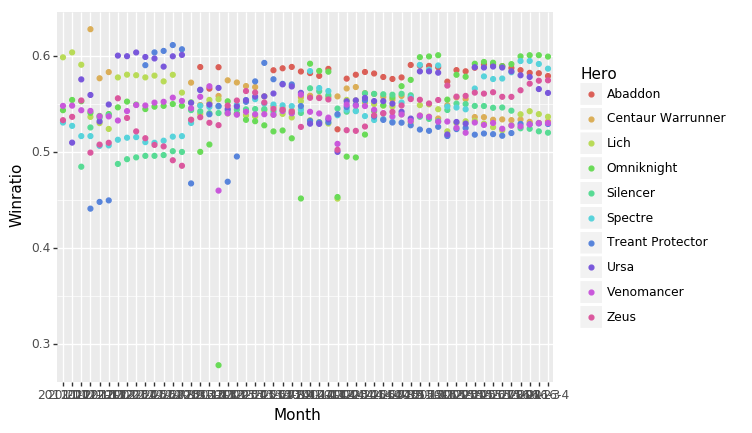

<ggplot: (8753189441491)>

In [0]:
month_plot = (ggplot(df_highest_winratio.groupby(["Month", "Hero"]).mean().reset_index(), aes(x="Month", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
month_plot

In [0]:
month_plot.save("highest_winratio_month_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_month_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


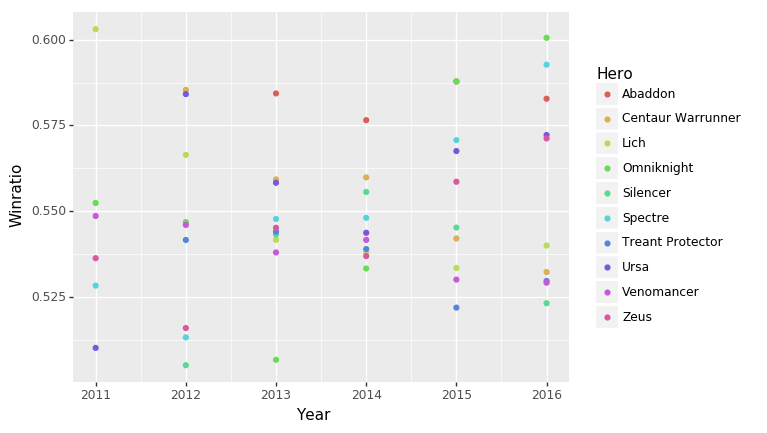

<ggplot: (8753189978183)>

In [0]:
year_plot = (ggplot(df_highest_winratio.groupby(["Year", "Hero"]).mean().reset_index(), aes(x="Year", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
year_plot

In [0]:
year_plot.save("highest_winratio_year_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: most_popular_year_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


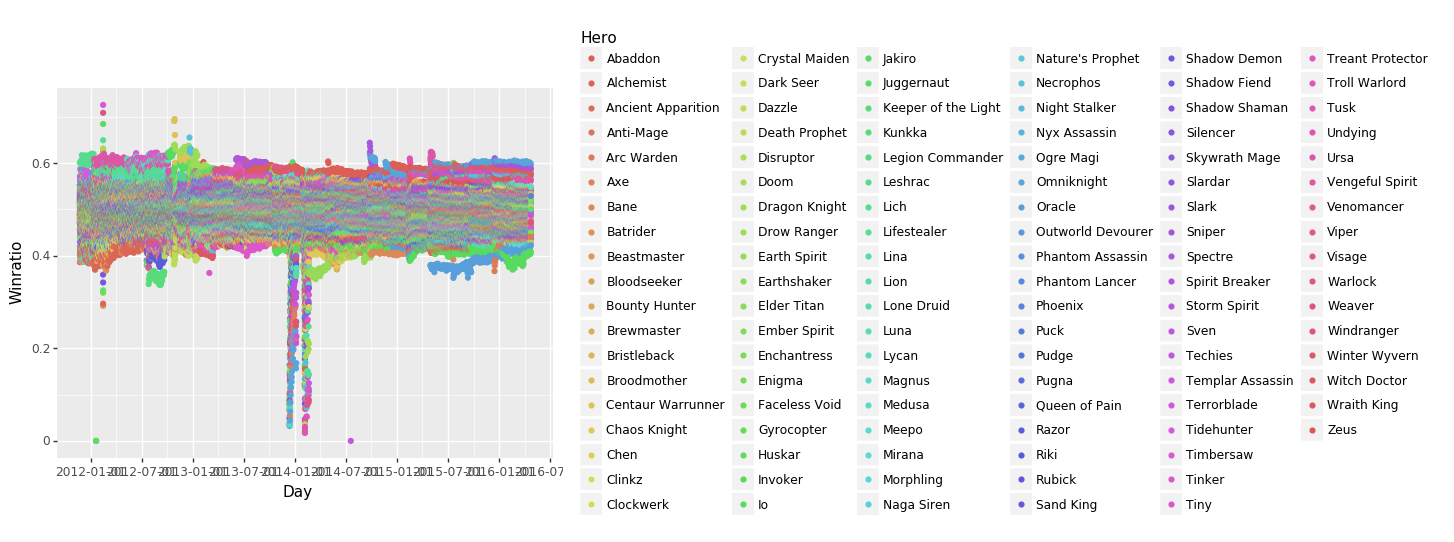

<ggplot: (-9223363283664690751)>

In [0]:
all_day_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_point()
             )
all_day_plot

In [0]:
all_day_plot.save("winratio_all_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 32 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: winratio_all_day_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


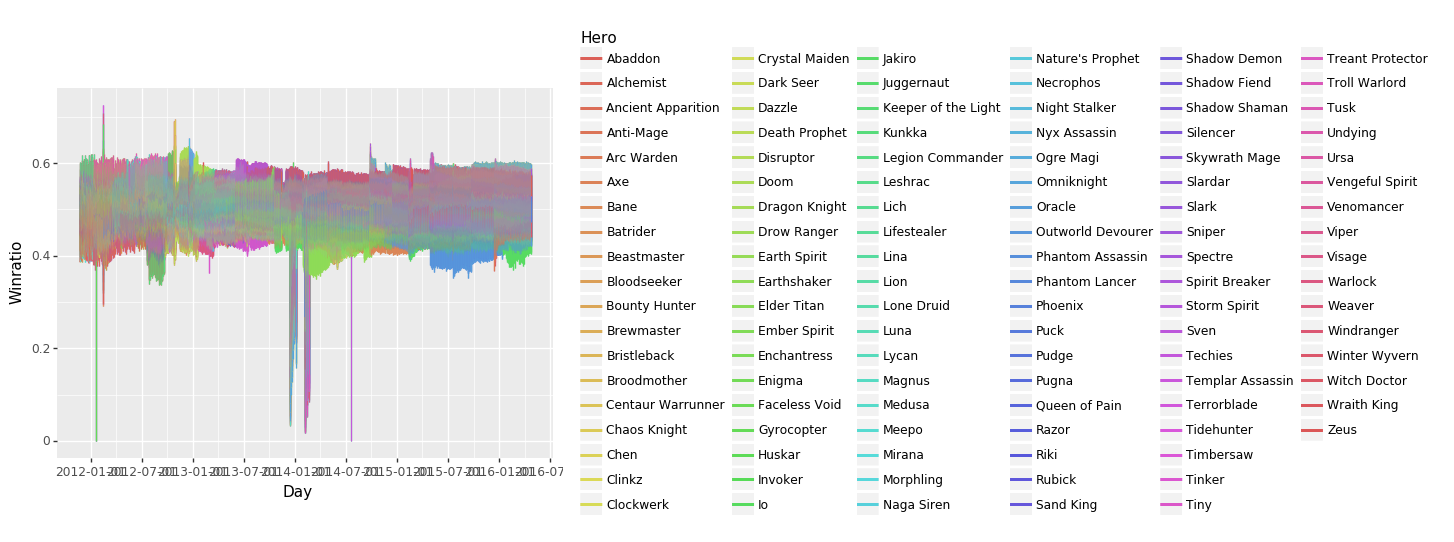

<ggplot: (-9223363283664882172)>

In [0]:
all_day_line_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio", color="Hero", group=1))
              +geom_line()
             )
all_day_line_plot

/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


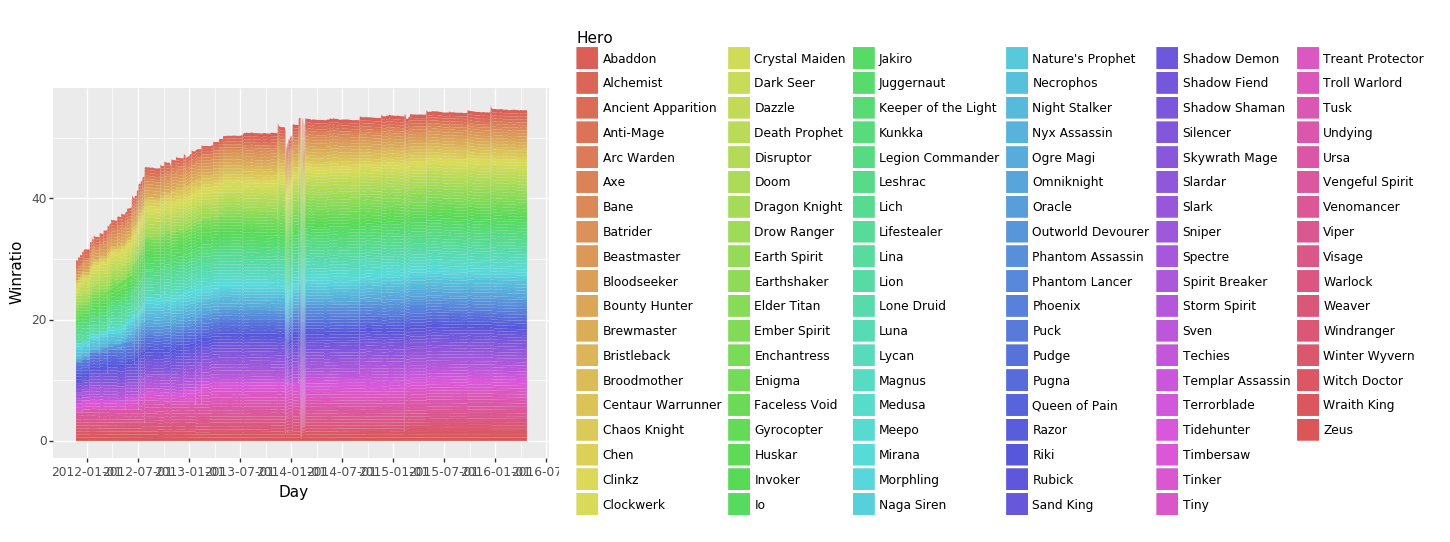

<ggplot: (8753189785352)>

In [0]:
all_day_stacked_plot = (ggplot(df_expl_graph, aes(x="Day", y="Winratio"))
              +geom_area(aes(fill="Hero"))
             )
all_day_stacked_plot

In [0]:
all_day_stacked_plot.save("winratio_all_day_stacked_plot.png", width=44, height=12, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 44 x 12 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: winratio_all_day_stacked_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


#### Detect changes over time

In [0]:
def previous_distribution_vector(df, date_start, date_end, average_function="mean"):
  df_filtered = df[(df["Day"] >= date_start) & (df["Day"] < date_end)]
  
  if average_function == "median":
    result = df_filtered.groupby(["Hero"]).median()[["Winratio"]]
  else:
    result = df_filtered.groupby(["Hero"]).mean()[["Winratio"]]
  
  return result.to_dict()["Winratio"]

In [0]:
def compute_distance(day, previous_period_average, distance_function=distance.euclidean):
  previous = [value for key, value 
              in sorted(previous_period_average.items(), key=lambda x: x[0]) if key in day.keys()]
  current = [value for key, value 
              in sorted(day.items(), key=lambda x: x[0]) if key in previous_period_average.keys()]
  assert len(previous) == len(current), "Incorrect length: previous-> {}, current-> {}".format(len(previous), len(current))
  
  return distance_function(previous, current)
  

In [0]:
def day_difference(df, day, distance_function=distance.euclidean, length=14, average_function="mean"):
  # Extract vector for day
  day_picks = {record["Hero"]: record["Winratio"] for record 
               in df[df["Day"] == day][["Hero", "Winratio"]].to_dict('records')
              }
  previous_picks = previous_distribution_vector(df, datetime.strptime(day, '%Y-%m-%d') - timedelta(days=length), day, average_function)
  
  return compute_distance(day_picks, previous_picks, distance_function)

In [0]:
def all_days_difference(df, distance_function=distance.euclidean, length=14, average_function="mean"):
  all_days = [str(d) for d in sorted(set(date.date() for key, date in df["Day"].to_dict().items()))[1:]]
  
  return {day: day_difference(
      df, day, distance_function=distance.euclidean, 
      length=14, average_function="mean") 
   for day in all_days}

In [0]:
# Try to graph differences for top 10 champions by win ratio

high_winratio_differences_by_day = all_days_difference(df_highest_winratio).items()
sorted_high_winratio_differences_by_day = sorted(high_winratio_differences_by_day, key=lambda x: x[1], reverse=True)
df_high_winratio_differences_by_day = pd.DataFrame(high_winratio_differences_by_day)
df_high_winratio_differences_by_day.columns = ["Day", "Difference"]
df_high_winratio_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.042579
1,2011-11-25,0.023407
2,2011-11-26,0.037935
3,2011-11-27,0.024937
4,2011-11-28,0.024312


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


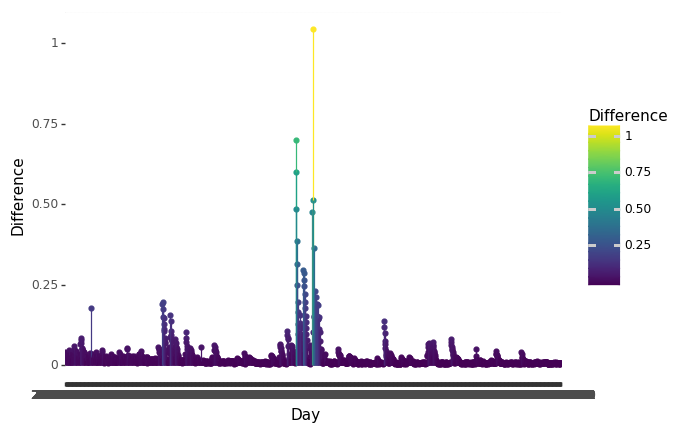

<ggplot: (8753189747071)>

In [0]:
high_winratio_differences_plot = (
    ggplot(df_high_winratio_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

high_winratio_differences_plot

In [0]:
high_winratio_differences_plot.save("high_winratio_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 40 x 2 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: differences_plot.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


In [0]:
# Try to graph differences for top 10 champions by std
high_std_differences_by_day = all_days_difference(df_winratio_std).items()
sorted_std_differences_by_day = sorted(high_std_differences_by_day, key=lambda x: x[1], reverse=True)
df_high_std_differences_by_day = pd.DataFrame(high_std_differences_by_day)
df_high_std_differences_by_day.columns = ["Day", "Difference"]
df_high_std_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.053866
1,2011-11-25,0.046800
2,2011-11-26,0.016963
3,2011-11-27,0.028330
4,2011-11-28,0.027055


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


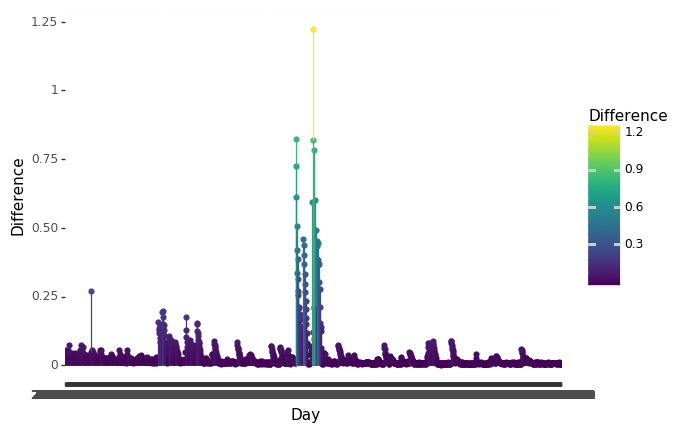

<ggplot: (-9223363283665671985)>

In [0]:
high_std_differences_plot = (
    ggplot(df_high_std_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

high_std_differences_plot

In [19]:
# Try to graph differences for all heroes

all_differences_by_day = all_days_difference(df_expl_graph).items()
sorted_all_differences_by_day = sorted(all_differences_by_day, key=lambda x: x[1], reverse=True)
df_all_differences_by_day = pd.DataFrame(all_differences_by_day)
df_all_differences_by_day.columns = ["Day", "Difference"]
df_all_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.130350
1,2011-11-25,0.102137
2,2011-11-26,0.109254
3,2011-11-27,0.104259
4,2011-11-28,0.095468


/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


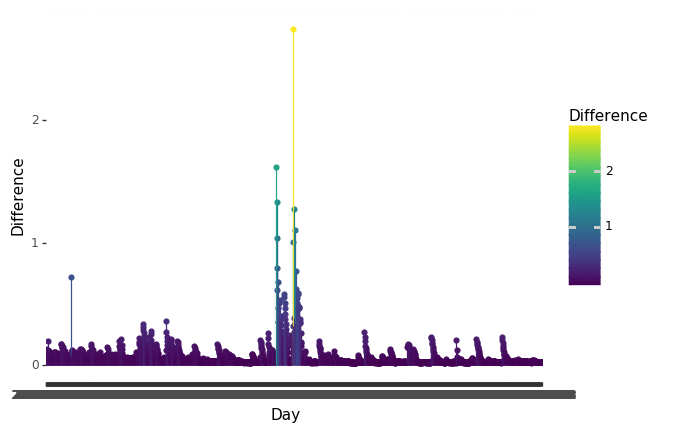

<ggplot: (8752073315662)>

In [20]:
all_heroes_differences_plot = (
    ggplot(df_all_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

all_heroes_differences_plot

In [115]:
poster_differences_plot = (
    ggplot(df_all_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point(size=0.25, alpha=0.75)
    +geom_area(aes(fill="Difference"))
    +scale_color_gradient(low="#5D5DA9", high="#DC5657")
    +scale_fill_gradient(low="#5D5DA9", high="#DC5657")
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +xlab("")
    +theme(
        text=element_text(family=['serif']),
        panel_background=element_rect(fill="white", colour="white"),
        panel_grid=element_blank(),
        axis_text=element_text(size=24.0),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        axis_text_x=element_text(size=14.0, family=['Dejavu Sans', 'Dejavu']),
        legend_text=element_text(family=['Dejavu Sans', 'Dejavu']),
        legend_title=element_blank(),
    )
)

# poster_differences_plot
poster_differences_plot.save("poster_winratio_differences_white_15x4.5.png", width=15, height=4.5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 4.5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_winratio_differences_white_15x4.5.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 ro

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 14966 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


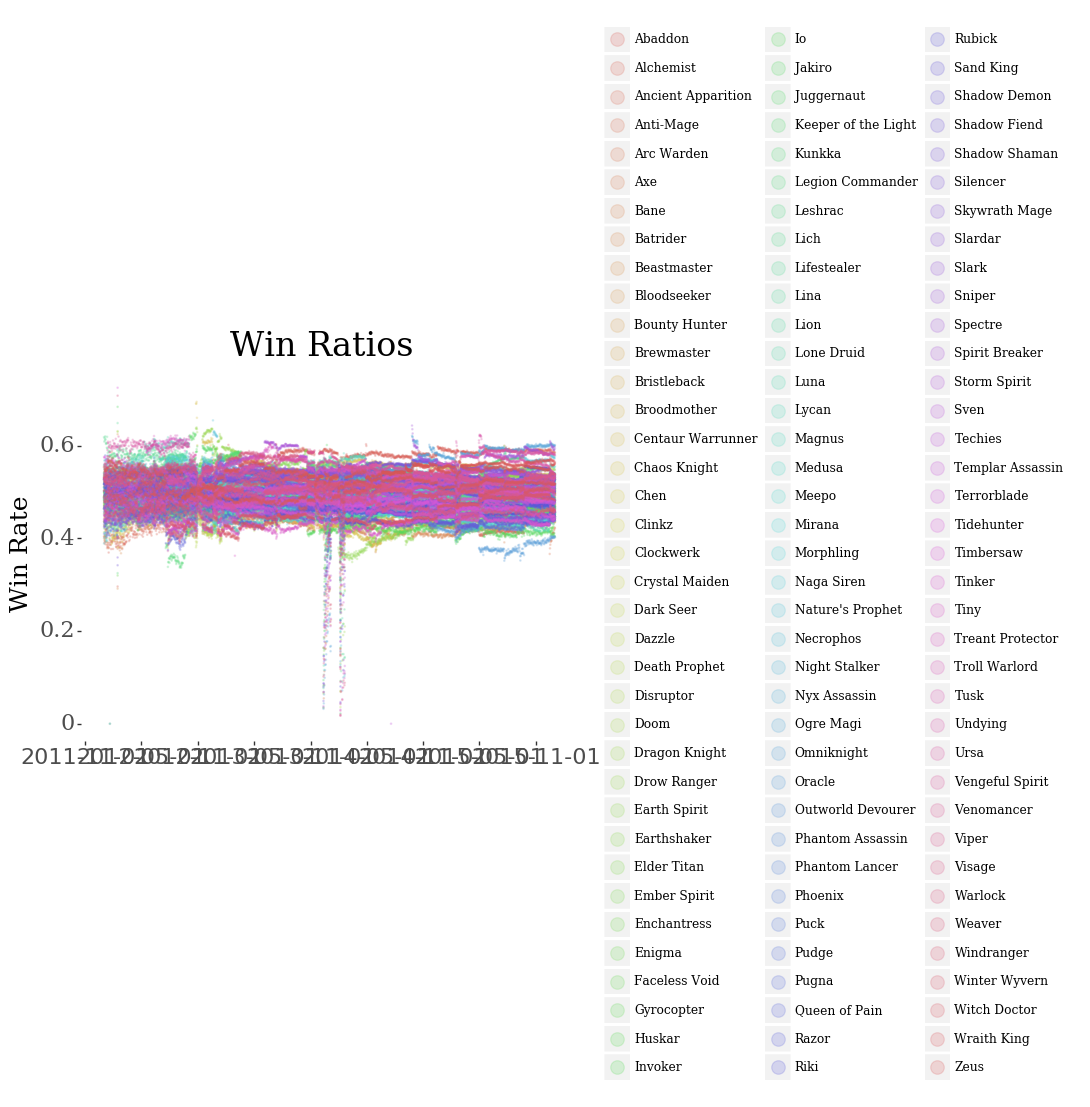

<ggplot: (8752063979149)>

In [56]:
poster_stacked = (
    ggplot(df_expl_graph, aes(x="Day", y="Winratio"))
    +geom_point(aes(fill="Hero", color="Hero"), size=0.1, alpha=0.2)
    +guides(color=guide_legend(ncol=3, title="Heroes", override_aes=aes(size=5)), fill=guide_legend(ncol=3, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Win Ratios")
    +xlab("")
    +ylab("Win Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=16.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=18.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=24.0),
        axis_text_x=element_text(size=16.0, family=['Dejavu Sans', 'Dejavu']),#, angle=45),
        panel_background=element_rect(fill="white", colour="white"),
        legend_background=element_blank()
    )
)
poster_stacked
#poster_stacked.save("poster_stacked_white_46x12.png", width=17, height=11, dpi=300, limitsize=False)

In [57]:
poster_stacked.save("poster_winratio_white_17x11.png", width=17, height=11, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 17 x 11 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_winratio_white_17x11.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 14966 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


## Top 10 heroes

In [0]:
top_10_heroes = df_popularity.sort_values("Count", ascending=False)[:10]["Hero"]

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1414 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


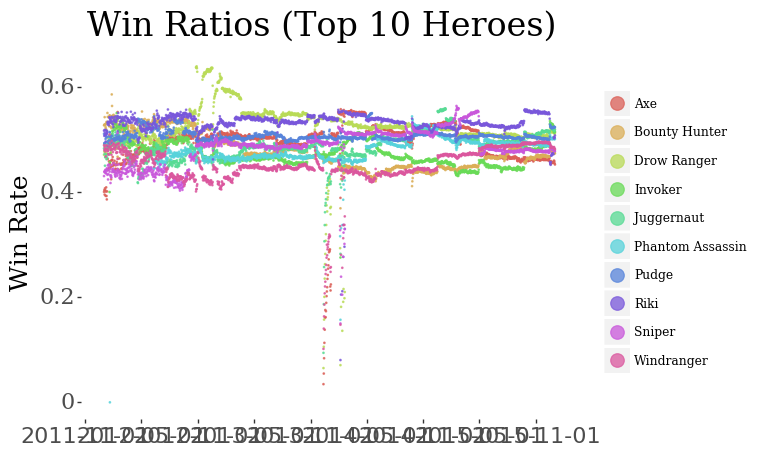

<ggplot: (-9223363284789883553)>

In [106]:
poster_stacked = (
    ggplot(df_expl_graph[df_expl_graph["Hero"].isin(top_10_heroes)], aes(x="Day", y="Winratio"))
    +geom_point(aes(fill="Hero", color="Hero"), size=0.1, alpha=0.75)
    +guides(color=guide_legend(ncol=1, title="Heroes", override_aes=aes(size=5, alpha=0.75)), fill=guide_legend(ncol=3, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Win Ratios (Top 10 Heroes)")
    +xlab("")
    +ylab("Win Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=16.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=18.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=24.0),
        axis_text_x=element_text(size=16.0, family=['Dejavu Sans', 'Dejavu']),#, angle=45),
        panel_background=element_rect(fill="white", colour="white"),
        legend_background=element_blank()
    )
)
poster_stacked
#poster_stacked.save("poster_stacked_white_46x12.png", width=17, height=11, dpi=300, limitsize=False)

In [107]:
poster_stacked.save("poster_winratio_top_10_17x11.png", width=17, height=11, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 17 x 11 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_winratio_top_10_17x11.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1414 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [108]:
# Try to graph differences for top 10 champions
high_std_differences_by_day = all_days_difference(df_expl_graph[df_expl_graph["Hero"].isin(top_10_heroes)]).items()
sorted_std_differences_by_day = sorted(high_std_differences_by_day, key=lambda x: x[1], reverse=True)
df_high_std_differences_by_day = pd.DataFrame(high_std_differences_by_day)
df_high_std_differences_by_day.columns = ["Day", "Difference"]
df_high_std_differences_by_day.head()

,Day,Difference
0,2011-11-24,0.030249
1,2011-11-25,0.017232
2,2011-11-26,0.009502
3,2011-11-27,0.032486
4,2011-11-28,0.023283


In [113]:
poster_differences_plot = (
    ggplot(df_high_std_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point(size=0.25, alpha=0.75)
    +geom_area(aes(fill="Difference"))
    +scale_color_gradient(low="#5D5DA9", high="#DC5657")
    +scale_fill_gradient(low="#5D5DA9", high="#DC5657")
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +xlab("")
    +theme(
        text=element_text(family=['serif']),
        panel_background=element_rect(fill="white", colour="white"),
        panel_grid=element_blank(),
        axis_text=element_text(size=24.0),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        axis_text_x=element_text(size=14.0, family=['Dejavu Sans', 'Dejavu']),
        legend_text=element_text(family=['Dejavu Sans', 'Dejavu']),
        legend_title=element_blank(),
    )
)

# poster_differences_plot
poster_differences_plot.save("poster_winratio_differences_top_10_15x4_5.png", width=15, height=4.5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 4.5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_winratio_differences_top_10_15x4_5.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 r

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


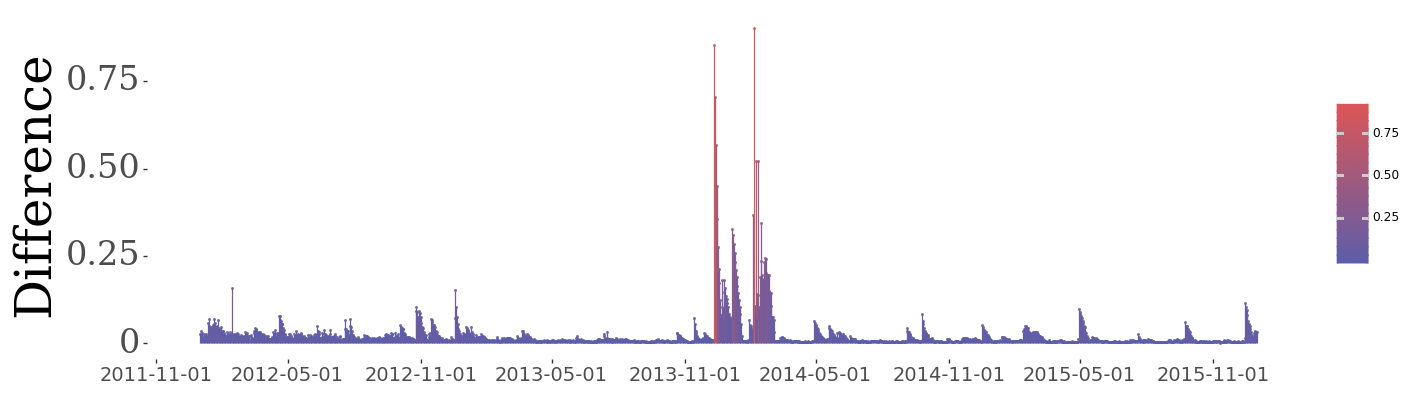

<ggplot: (-9223363284786054477)>

In [114]:
poster_differences_plot